In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import pytz
import os
#import gdown
import matplotlib.pyplot as plt
from matplotlib import style
from pandas import DataFrame
import statsmodels.api as sm
import seaborn as sbn
from IPython.display import Image
from IPython.core.display import HTML
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import signal
import scipy.stats as stats
from math import sqrt
from sklearn.metrics import mean_squared_error

Dataset load and preprocessing

In [3]:
Dataset = pd.read_csv("solar_wind.csv")

In [4]:
Dataset.head()

,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source
0,train_a,0 days 00:00:00,-5.55,3.00,1.25,11.09,153.37,-5.55,3.00,1.25,11.09,153.37,6.80,1.53,383.92,110237.0,ac
1,train_a,0 days 00:01:00,-5.58,3.16,1.17,10.10,151.91,-5.58,3.16,1.17,10.10,151.91,6.83,1.69,381.79,123825.0,ac
2,train_a,0 days 00:02:00,-5.15,3.66,0.85,7.87,146.04,-5.15,3.66,0.85,7.87,146.04,6.77,1.97,389.11,82548.0,ac
3,train_a,0 days 00:03:00,-5.20,3.68,0.68,6.17,146.17,-5.20,3.68,0.68,6.17,146.17,6.74,1.97,389.11,82548.0,ac
4,train_a,0 days 00:04:00,-5.12,3.68,0.49,4.62,145.72,-5.12,3.68,0.49,4.62,145.72,6.65,1.77,384.26,94269.0,ac


In [5]:
Dataset.tail()

,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source
8392315,train_c,2435 days 23:55:00,-1.18,2.00,-3.92,-59.28,120.51,-1.17,2.98,-3.23,-45.24,111.48,4.56,4.64,348.73,23368.0,ac
8392316,train_c,2435 days 23:56:00,-1.34,2.12,-3.83,-56.78,122.23,-1.33,3.08,-3.12,-42.95,113.45,4.58,4.27,346.36,26497.0,ac
8392317,train_c,2435 days 23:57:00,-1.62,2.33,-3.63,-51.98,124.76,-1.61,3.22,-2.87,-38.57,116.58,4.61,3.95,344.12,27050.0,ac
8392318,train_c,2435 days 23:58:00,-2.27,2.48,-3.22,-43.81,132.50,-2.26,3.25,-2.44,-31.61,124.81,4.65,2.81,338.52,33257.0,ac
8392319,train_c,2435 days 23:59:00,-2.15,2.41,-3.30,-45.55,131.76,-2.15,3.21,-2.53,-33.21,123.75,4.62,2.30,342.31,32267.0,ac


Since the dataset has 3 data trains, and since the entire dataset contains 8M3 of data, I choose to keep only train_a.

In [6]:
Dataset_A = Dataset.loc[Dataset['period']=='train_a']

In [7]:
Dataset_A.tail()

,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source
1729435,train_a,1200 days 23:55:00,-4.07,3.06,-1.54,-16.78,143.08,-4.07,3.39,-0.47,-5.09,140.20,5.32,6.05,339.02,43507.0,ac
1729436,train_a,1200 days 23:56:00,-3.35,3.40,-1.43,-16.63,134.59,-3.35,3.68,-0.26,-2.98,132.32,4.98,5.37,338.51,42298.0,ac
1729437,train_a,1200 days 23:57:00,-3.27,3.42,-1.29,-15.22,133.66,-3.27,3.65,-0.12,-1.42,131.78,4.90,5.18,342.72,38547.0,ac
1729438,train_a,1200 days 23:58:00,-3.26,3.47,-1.07,-12.72,133.19,-3.25,3.63,0.09,1.11,131.87,4.88,5.60,338.74,42813.0,ac
1729439,train_a,1200 days 23:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Addition of a datetime column as index.

In [8]:
Dataset_A["Date-Time"] = pd.date_range(start='9/1/2002', periods=len(Dataset_A), freq='min')

C:\Users\Augusto\AppData\Local\Temp/ipykernel_3276/353912719.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataset_A["Date-Time"] = pd.date_range(start='9/1/2002', periods=len(Dataset_A), freq='min')


In [9]:
Dataset_A['Date-Time'].dt.tz_localize(None)
Dataset_A.index = Dataset_A['Date-Time']
Dataset_A.index

DatetimeIndex(['2002-09-01 00:00:00', '2002-09-01 00:01:00',
               '2002-09-01 00:02:00', '2002-09-01 00:03:00',
               '2002-09-01 00:04:00', '2002-09-01 00:05:00',
               '2002-09-01 00:06:00', '2002-09-01 00:07:00',
               '2002-09-01 00:08:00', '2002-09-01 00:09:00',
               ...
               '2005-12-14 23:50:00', '2005-12-14 23:51:00',
               '2005-12-14 23:52:00', '2005-12-14 23:53:00',
               '2005-12-14 23:54:00', '2005-12-14 23:55:00',
               '2005-12-14 23:56:00', '2005-12-14 23:57:00',
               '2005-12-14 23:58:00', '2005-12-14 23:59:00'],
              dtype='datetime64[ns]', name='Date-Time', length=1729440, freq=None)

3 - Analysis and description of the dataset.

In [10]:
Dataset_A

,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source,Date-Time
Date-Time,,,,,,,,,,,,,,,,,,
2002-09-01 00:00:00,train_a,0 days 00:00:00,-5.55,3.00,1.25,11.09,153.37,-5.55,3.00,1.25,11.09,153.37,6.80,1.53,383.92,110237.0,ac,2002-09-01 00:00:00
2002-09-01 00:01:00,train_a,0 days 00:01:00,-5.58,3.16,1.17,10.10,151.91,-5.58,3.16,1.17,10.10,151.91,6.83,1.69,381.79,123825.0,ac,2002-09-01 00:01:00
2002-09-01 00:02:00,train_a,0 days 00:02:00,-5.15,3.66,0.85,7.87,146.04,-5.15,3.66,0.85,7.87,146.04,6.77,1.97,389.11,82548.0,ac,2002-09-01 00:02:00
2002-09-01 00:03:00,train_a,0 days 00:03:00,-5.20,3.68,0.68,6.17,146.17,-5.20,3.68,0.68,6.17,146.17,6.74,1.97,389.11,82548.0,ac,2002-09-01 00:03:00
2002-09-01 00:04:00,train_a,0 days 00:04:00,-5.12,3.68,0.49,4.62,145.72,-5.12,3.68,0.49,4.62,145.72,6.65,1.77,384.26,94269.0,ac,2002-09-01 00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-14 23:55:00,train_a,1200 days 23:55:00,-4.07,3.06,-1.54,-16.78,143.08,-4.07,3.39,-0.47,-5.09,140.20,5.32,6.05,339.02,43507.0,ac,2005-12-14 23:55:00
2005-12-14 23:56:00,train_a,1200 days 23:56:00,-3.35,3.40,-1.43,-16.63,134.59,-3.35,3.68,-0.26,-2.98,132.32,4.98,5.37,338.51,42298.0,ac,2005-12-14 23:56:00
2005-12-14 23:57:00,train_a,1200 days 23:57:00,-3.27,3.42,-1.29,-15.22,133.66,-3.27,3.65,-0.12,-1.42,131.78,4.90,5.18,342.72,38547.0,ac,2005-12-14 23:57:00


In [11]:
Dataset_A.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1729440 entries, 2002-09-01 00:00:00 to 2005-12-14 23:59:00
Data columns (total 18 columns):
 #   Column       Dtype         
---  ------       -----         
 0   period       object        
 1   timedelta    object        
 2   bx_gse       float64       
 3   by_gse       float64       
 4   bz_gse       float64       
 5   theta_gse    float64       
 6   phi_gse      float64       
 7   bx_gsm       float64       
 8   by_gsm       float64       
 9   bz_gsm       float64       
 10  theta_gsm    float64       
 11  phi_gsm      float64       
 12  bt           float64       
 13  density      float64       
 14  speed        float64       
 15  temperature  float64       
 16  source       object        
 17  Date-Time    datetime64[ns]
dtypes: datetime64[ns](1), float64(14), object(3)
memory usage: 250.7+ MB


The dataset contains 1729440 records with 14 columns of measurements made by the satellite, starting on 09/01/2002 and the last one corresponding to 12/14/2005. This corresponds to 1200 days of measurements. Measurements are with a time interval of 1 minute.

In [12]:
dosdias = Dataset_A.loc['24/09/2004 00:00:00':'25/09/2004 23:59:00']

In [13]:
diezdias = Dataset_A.loc['20/09/2004 00:00:00':'30/09/2004 23:59:00']

In [14]:
diezdias.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15840 entries, 2004-09-20 00:00:00 to 2004-09-30 23:59:00
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   period       15840 non-null  object        
 1   timedelta    15840 non-null  object        
 2   bx_gse       15437 non-null  float64       
 3   by_gse       15437 non-null  float64       
 4   bz_gse       15437 non-null  float64       
 5   theta_gse    15437 non-null  float64       
 6   phi_gse      15437 non-null  float64       
 7   bx_gsm       15437 non-null  float64       
 8   by_gsm       15437 non-null  float64       
 9   bz_gsm       15437 non-null  float64       
 10  theta_gsm    15437 non-null  float64       
 11  phi_gsm      15437 non-null  float64       
 12  bt           15437 non-null  float64       
 13  density      14690 non-null  float64       
 14  speed        14690 non-null  float64       
 15  temperature  14356

The dataset trimmed to 10 days contains 351,360 records with 14 columns of measurements made by the satellite, starting on 09/01/2002 and the last one corresponding to 10/10/2002.

In [15]:
docemeses=Dataset_A.loc['01/09/2004 00:00:00':'30/08/2005 23:59:00']

In [16]:
docemeses.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 864000 entries, 2004-01-09 00:00:00 to 2005-08-30 23:59:00
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   period       864000 non-null  object        
 1   timedelta    864000 non-null  object        
 2   bx_gse       814698 non-null  float64       
 3   by_gse       814698 non-null  float64       
 4   bz_gse       814698 non-null  float64       
 5   theta_gse    814698 non-null  float64       
 6   phi_gse      814698 non-null  float64       
 7   bx_gsm       814698 non-null  float64       
 8   by_gsm       814698 non-null  float64       
 9   bz_gsm       814698 non-null  float64       
 10  theta_gsm    814698 non-null  float64       
 11  phi_gsm      814698 non-null  float64       
 12  bt           814698 non-null  float64       
 13  density      751787 non-null  float64       
 14  speed        751816 non-null  float64       
 15  

3.1 - Selection of a variable to study  
*   bz_gse = interplanetary magnetic field in the z axis, this is perpendicular to the ecliptic and is created by waves and other disturbances in the solar wind.

In [17]:
variable = 'bz_gse'
#docemeses[variable].isnull()
docemeses = docemeses.interpolate(method ='ffill', limit_direction ='forward')
Dataset_A[variable].describe()

count    1.575012e+06
mean    -2.088664e-01
std      4.353029e+00
min     -5.305000e+01
25%     -2.660000e+00
50%     -1.700000e-01
75%      2.280000e+00
max      7.403000e+01
Name: bz_gse, dtype: float64

In [18]:
Dataset_A[Dataset_A.isnull()].count()

period         0
timedelta      0
bx_gse         0
by_gse         0
bz_gse         0
theta_gse      0
phi_gse        0
bx_gsm         0
by_gsm         0
bz_gsm         0
theta_gsm      0
phi_gsm        0
bt             0
density        0
speed          0
temperature    0
source         0
Date-Time      0
dtype: int64

In [19]:
sbn.set(rc={'figure.figsize':(15, 5)})

Text(0, 0.5, 'B [nTesla]')

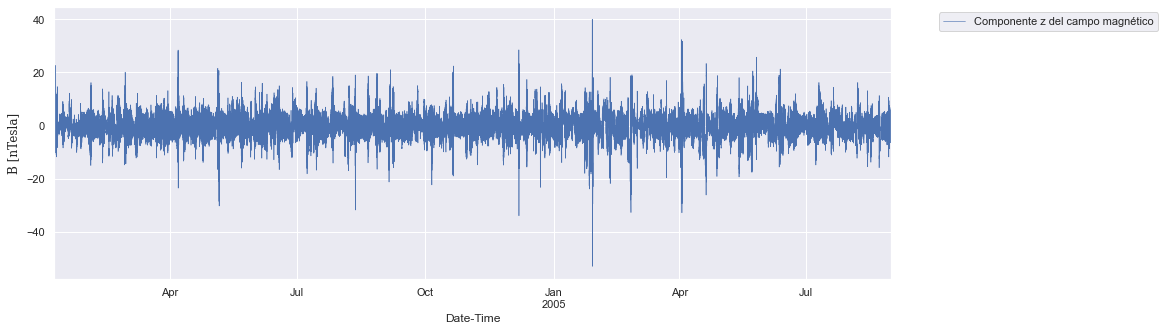

In [20]:
docemeses[variable].plot(linewidth=0.6, label="Componente z del campo magnético")#variable)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)

In [21]:
sbn.set(rc={'figure.figsize':(15, 5)})

Text(0, 0.5, 'B [nTesla]')

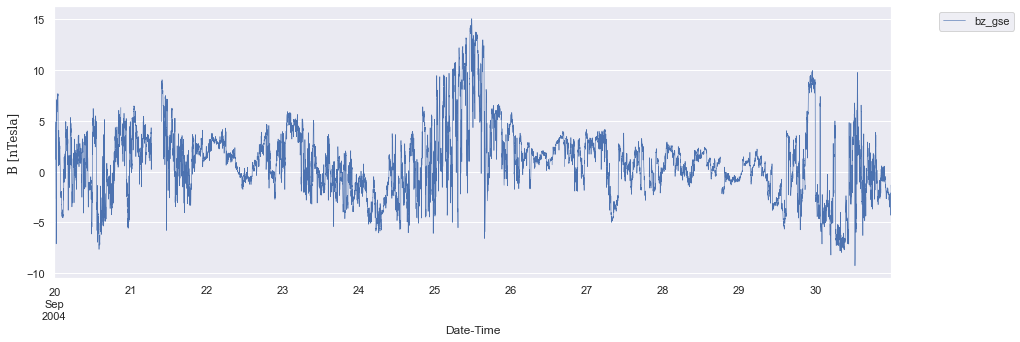

In [22]:
diezdias[variable].plot(linewidth=0.6, label=variable)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)

In [23]:
sbn.set(rc={'figure.figsize':(15, 5)})

Text(0, 0.5, 'B [nTesla]')

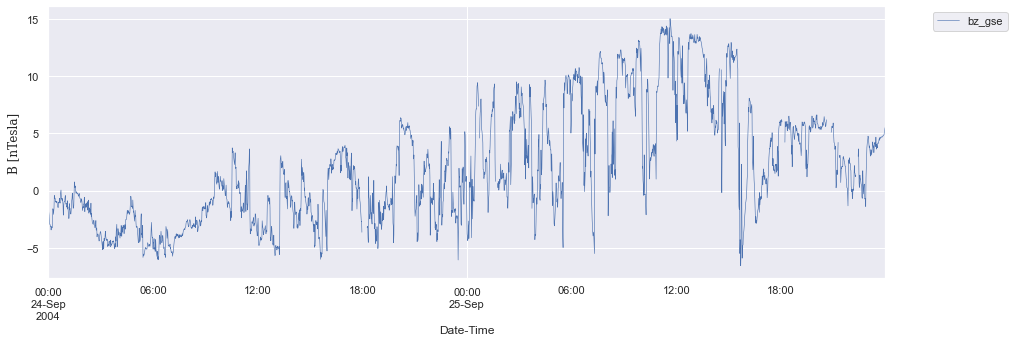

In [24]:
dosdias[variable].plot(linewidth=0.6, label=variable)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)

In [25]:
sbn.set(rc={'figure.figsize':(15, 5)})